In [1]:
import sys
from collections import Counter

import sympy
import dill
import numpy as np
from IPython.display import display
from sympy import latex, init_printing

sys.path.append("../")
import Diplotype as dp

from bokeh.plotting import figure, output_notebook, show
from bokeh.models import Range1d
from bokeh.io import push_notebook
from ipywidgets import interact

output_notebook()

Loading BokehJS ...

In [2]:
#reverse haldane
def M_to_r(M):
    return 0.5*(1 - np.exp(-2*M))

#reverse haldane function for numpy vectors
recfun = np.vectorize(M_to_r)

## Population setup

A four-way with founder alleles $\{A,B,C,D\}$ coded as $\{0,1,2,3\}$. 

A Population is a tuple of Diplotype objects. 

A Diplotype object contains two haplotypes and the probability with which the diplotype was created from meiosis of it's parent(s).

The Population binds methods for dealing with groups of dipotypes, such as grouping them into sets that with identical two-locus haplotypes or genotypes.

A key method for testing vs. simulations is Population.tofunc() - to create functions that generate the probability of the Diplotype given a probability of meiotic recombination between the loci. 

Both Diplotypes and Populations rely heavily on sympy.

Diplotype objects are stored with *Hap1|Hap2* notation:

In [3]:
example = dp.Diplotype(['AA', 'BD'])
print('representation: {}'.format(example))
print('locus genotypes: {}'.format([x for x in [example.locus1, example.locus2]]))

representation: AA|BD
locus genotypes: ['AB', 'AD']


They can be selfed to create offspring that keep track of their probabilities of generation, and these are stored as Population class instances:

In [4]:
selfed = example.selfmate()
display(type(selfed))
display(selfed)

Diplotype.Population

(Diplotype(('AA', 'AA'), (-r/2 + 1/2)**2),
 Diplotype(('AA', 'BD'), (-r/2 + 1/2)**2),
 Diplotype(('AA', 'AD'), r*(-r/2 + 1/2)/2),
 Diplotype(('AA', 'BA'), r*(-r/2 + 1/2)/2),
 Diplotype(('AA', 'BD'), (-r/2 + 1/2)**2),
 Diplotype(('BD', 'BD'), (-r/2 + 1/2)**2),
 Diplotype(('AD', 'BD'), r*(-r/2 + 1/2)/2),
 Diplotype(('BA', 'BD'), r*(-r/2 + 1/2)/2),
 Diplotype(('AA', 'AD'), r*(-r/2 + 1/2)/2),
 Diplotype(('AD', 'BD'), r*(-r/2 + 1/2)/2),
 Diplotype(('AD', 'AD'), r**2/4),
 Diplotype(('AD', 'BA'), r**2/4),
 Diplotype(('AA', 'BA'), r*(-r/2 + 1/2)/2),
 Diplotype(('BA', 'BD'), r*(-r/2 + 1/2)/2),
 Diplotype(('AD', 'BA'), r**2/4),
 Diplotype(('BA', 'BA'), r**2/4))

## Create a fourway by selfing population

In [5]:
r,k = sympy.symbols('r k')  # r = recombination, k = generation; needed to construct equations
intermediate_1 = dp.Diplotype.from_string("AA|BB")
intermediate_2 = dp.Diplotype.from_string("CC|DD")
F1 = dp.Diplotype.cross(intermediate_1, intermediate_2).combine()
fourway = dict()
fourway['cycle1'] = F1.cycle().combine() #self an F1 and combine like diplotypes to create the F2
fourway['cycle2'] = fourway['cycle1'].cycle().combine() #combining like diplotypes keeps the population from exploding
fourway['cycle3'] = fourway['cycle2'].cycle().combine()
fourway['cycle4'] = fourway['cycle3'].cycle().combine()

For any population, the diplotype probabilities can be turned into equations as a function of recombination rate. These are stored as unphased genotypes with locus1 and locus2 appearing consecutively. For example, *DB|AB* would become *'ADBB'*.

Taking symmetries into account (i.e. AA|CC == CC|AA), there are 64 possible diplotypes from a symmetrical fourway by selfing.

In [6]:
equations = dict()
equations['fourway'] = dict()
for key, value in fourway.items():
    equations['fourway'][key] = value.tofunc()
dips = sorted(list(equations['fourway']['cycle3'].keys()))
print('Fourway cycle3:\n{} Genotypes: {}'.format(len(dips), dips))

Fourway cycle3:
64 Genotypes: ['AAAA', 'AAAC', 'AAAD', 'AABB', 'AABC', 'AABD', 'AACC', 'AADD', 'ACAA', 'ACAC', 'ACAD', 'ACBB', 'ACBC', 'ACBD', 'ACCC', 'ACDD', 'ADAA', 'ADAC', 'ADAD', 'ADBB', 'ADBC', 'ADBD', 'ADCC', 'ADDD', 'BBAA', 'BBAC', 'BBAD', 'BBBB', 'BBBC', 'BBBD', 'BBCC', 'BBDD', 'BCAA', 'BCAC', 'BCAD', 'BCBB', 'BCBC', 'BCBD', 'BCCC', 'BCDD', 'BDAA', 'BDAC', 'BDAD', 'BDBB', 'BDBC', 'BDBD', 'BDCC', 'BDDD', 'CCAA', 'CCAC', 'CCAD', 'CCBB', 'CCBC', 'CCBD', 'CCCC', 'CCDD', 'DDAA', 'DDAC', 'DDAD', 'DDBB', 'DDBC', 'DDBD', 'DDCC', 'DDDD']


Just an example - of one of the equations. They are polynomials.

'Fourway Selfing Generation 3:'

"Diplotype ('AB', 'AB')"

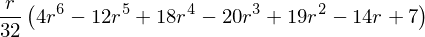

In [7]:
testdip = fourway['cycle3'][0]
display("Fourway Selfing Generation 3:")
display('Diplotype {}'.format(testdip.haplotypes))
init_printing()
testdip.prob.simplify()

## Set up a biparental

In [8]:
A = dp.Diplotype(('AA', 'AA'))
B = dp.Diplotype(('BB', 'BB'))
F1 = dp.Diplotype.cross(A,B)
biparental = dict()
biparental['cycle1'] = F1.cycle().combine()
biparental['cycle2'] = biparental['cycle1'].cycle().combine()
biparental['cycle3'] = biparental['cycle2'].cycle().combine()
biparental['cycle4'] = biparental['cycle3'].cycle().combine()

equations['biparental'] = dict()
for key, value in biparental.items():
    equations['biparental'][key] = value.tofunc()

## Load sim results and set up map

The simulation results are stored as a dict of lists of Counters:

* Each dict key is a cross type x generation (e.g. "fourway_2")
* Each dict value is a list of Counters:

     - Each Counter contains a key for each diplotype allele configuration
     - Each counter in the list corresponds to a map position
    
The map contains markers at intervals from 0.5 to 20 centimorgans with an 0.5cM step.

In [9]:
haps = dill.load(open('../data/countdict.pkl', 'rb'))
snp_pos = np.cumsum( np.arange(0,20.5,0.5)/100 )
snp_intervals = np.diff(snp_pos)
cM = snp_intervals * 100
print('pop types: {}\n'.format(haps.keys()))
print('map positions: {}'.format(cM))
print('diplotypes:\n')
display(haps['fourway_2'][-1].keys())

pop types: dict_keys(['fourway_3', 'fourway_4', 'biparental_2', 'biparental_1', 'fourway_2', 'biparental_4', 'biparental_3', 'fourway_1'])

map positions: [  0.5   1.    1.5   2.    2.5   3.    3.5   4.    4.5   5.    5.5   6.
   6.5   7.    7.5   8.    8.5   9.    9.5  10.   10.5  11.   11.5  12.
  12.5  13.   13.5  14.   14.5  15.   15.5  16.   16.5  17.   17.5  18.
  18.5  19.   19.5  20. ]
diplotypes:



dict_keys(['0131', '1112', '0102', '1313', '3232', '0133', '3032', '1013', '0103', '0132', '1331', '1023', '0232', '2020', '2222', '0323', '1020', '3133', '1030', '0122', '0331', '0230', '3333', '1113', '0231', '2123', '0023', '0121', '0003', '0202', '3132', '2122', '1032', '0033', '2023', '1321', '1012', '0000', '1212', '0020', '1323', '1221', '3030', '1232', '1231', '2323', '1220', '1010', '0220', '1320', '0032', '0030', '1133', '1131', '1230', '1111', '1022', '0222', '2022', '1121', '0320', '1132', '1122', '1333', '0022', '0330', '0101', '3131', '1123', '0303', '1222', '1033', '0321', '2121', '1330', '0333', '0123', '3033', '0221', '0002'])

These are stored as diplotypes, and must be converted to two-locus genotypes to match the equations.

In [10]:
genos = dict(zip('0 1 2 3'.split(), 'A B C D'.split()))

def dip_to_loc(dip):
    alleles = [genos[x] for x in dip]
    loc1 = sorted([alleles[0], alleles[2]])
    loc2 = sorted([alleles[1], alleles[3]])
    loc1 = ''.join(loc1)
    loc2 = ''.join(loc2)
    genotype = loc1 + loc2
    return genotype

print('EXAMPLE: Fourway sim, 3rd cycle of selfing')
phased = haps['fourway_3'][-1].keys()
unphased = Counter([dip_to_loc(x) for x in phased])
print('Phased: {}'.format(len(phased)))
print('Unphased: {}\n{}'.format(len(unphased), unphased))

EXAMPLE: Fourway sim, 3rd cycle of selfing
Phased: 80
Unphased: 64
Counter({'ADAD': 2, 'ACBD': 2, 'ADBC': 2, 'BCBC': 2, 'BCBD': 2, 'BDAC': 2, 'ACAD': 2, 'BCAC': 2, 'BDAD': 2, 'ACAC': 2, 'ADBD': 2, 'BDBC': 2, 'ACBC': 2, 'BCAD': 2, 'BDBD': 2, 'ADAC': 2, 'AAAC': 1, 'ADCC': 1, 'AABD': 1, 'BDAA': 1, 'CCAD': 1, 'BBDD': 1, 'CCAA': 1, 'BCDD': 1, 'BBBC': 1, 'ACCC': 1, 'ACAA': 1, 'BBBB': 1, 'CCBC': 1, 'ACBB': 1, 'BBAD': 1, 'ACDD': 1, 'ADAA': 1, 'AACC': 1, 'AADD': 1, 'AAAA': 1, 'AABB': 1, 'BBAC': 1, 'DDCC': 1, 'BDBB': 1, 'BBCC': 1, 'BBBD': 1, 'DDDD': 1, 'ADBB': 1, 'BCCC': 1, 'BBAA': 1, 'DDBB': 1, 'DDAC': 1, 'DDBD': 1, 'ADDD': 1, 'AAAD': 1, 'BCAA': 1, 'AABC': 1, 'CCCC': 1, 'CCDD': 1, 'CCBB': 1, 'CCAC': 1, 'BDDD': 1, 'DDAA': 1, 'DDAD': 1, 'DDBC': 1, 'BCBB': 1, 'BDCC': 1, 'CCBD': 1})


Convert all diplotypes to unphased genotypes.

In [11]:
sims = dict()
for crosstype in ['biparental', 'fourway']:
    sims[crosstype] = dict()
    for cycle in '1 2 3 4'.split():
        sims[crosstype]['cycle' + cycle] = list()
        pop = crosstype + '_' + cycle
        for interval in haps[pop]:
            mycount = Counter()
            for key, value in interval.items():
                newkey = dip_to_loc(key)
                tempcount = Counter({newkey: value})
                mycount += tempcount
            sims[crosstype]['cycle' + cycle].append(mycount)            

Use a couple examples to make sure this worked.

Both 'AA|CC' and 'AC|CA' will create 'ACAC' genotypes:

In [12]:
print("Example 1: Cycle3, last interval")
test = haps['fourway_3'][-1]
print('AA|CC: {}'.format(test['0022']))
print('AC|CA: {}'.format(test['0220']))
print('Combined: {}'.format(test['0022'] + test['0220']))
print('Result: {}\n'.format(sims['fourway']['cycle3'][-1]['ACAC']))

print("Example 2: Cycle4, -10th interval")
test = haps['fourway_4'][-10]
print('AA|CC: {}'.format(test['1133']))
print('AC|CA: {}'.format(test['1331']))
print('Combined: {}'.format(test['1133'] + test['1331']))
print('Result: {}\n'.format(sims['fourway']['cycle4'][-10]['BDBD']))

print(len(sims['fourway']['cycle4'][-10].keys()), len(equations['fourway']['cycle4'].keys()))

Example 1: Cycle3, last interval
AA|CC: 713
AC|CA: 100
Combined: 813
Result: 813

Example 2: Cycle4, -10th interval
AA|CC: 355
AC|CA: 36
Combined: 391
Result: 391

64 64


## Plot Setup

In [13]:
#function to prepare vectors for plotting
def plotprep(pop, cycle, genotype, nsamps=100000):
    if pop not in ['biparental', 'fourway']:
        raise ValueError('{} not valid pop setup'.format(pop))
    pop = str(pop)
    cycle = 'cycle' + str(cycle)
    #prepare results from equation
    eq = equations[pop][cycle][genotype]
    vals = eq(recfun(snp_intervals))
    
    #prepare sim results
    freqs = [x[genotype]/nsamps for x in sims[pop][cycle]]
    
    return (vals, freqs)

In [14]:
eq, sim = plotprep('biparental', '1', 'AAAA')
p = figure(plot_width=600, plot_height=600)
e = p.line(x=cM, y=eq, color="orange", legend="Diplotype", line_width=2)
s = p.scatter(x=cM, y=sim, legend="Simulation")
#p.x_range = Range1d(0, np.max(cM) + 2)
#p.y_range = Range1d(0, np.max(sim) + max(np.max(sim)*0.05, 0.02))

In [15]:
def update(pop, cycle, genotype):
    try:
        neweq, newsim = plotprep(pop, cycle, genotype)
        e.data_source.data['y'] = neweq
        s.data_source.data['y'] = newsim
        push_notebook()
    except KeyError:
        print('Not a valid genotype for Population {} Cycle {}: {}'.format(pop, cycle, genotype))
        print('Plot not updated')
        raise

In [16]:
pops = sorted(list(equations.keys()))
cycles = '1 2 3 4'.split()
genotypes = sorted(list(equations['fourway']['cycle4'].keys()))
show(p)

In [17]:
interact(update, pop=pops, cycle=cycles, genotype=genotypes)

<function __main__.update>

In [18]:
#create space for the widgets
for x in range(0,1500):
    print('')